In [1]:
%load_ext autoreload
%autoreload 2

from SO3 import so3_diffuser, SO3Algebra
from R3 import r3_diffuser
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import math
import math
import random
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from mpl_toolkits.mplot3d import Axes3D
import geoopt
from geoopt.optim import (RiemannianAdam)
Stiefel = geoopt.Stiefel()

In [2]:
import numpy as np
import torch
from scipy.spatial.transform import Rotation as SciRot

so3 = SO3Algebra()
# --- Generate a random rotation matrix via SciPy
R_np = SciRot.random().as_matrix()        # (3,3)
R_torch = torch.tensor(R_np, dtype=torch.float32).unsqueeze(0)   # (1,3,3)

# --- Step 1: log_map returns skew matrix (your design)
S_skew = so3.log_map(R_torch)             # (1,3,3)

# --- Step 2: get_v converts skew to axis-angle vector
log_pred = so3.get_v(S_skew)[0].detach().numpy()  # (3,)

# --- Step 3: ground-truth log vector from SciPy
log_gt = SciRot.from_matrix(R_np).as_rotvec()     # (3,)

# --- Step 4: compare axis-angle vectors
print("log vector (scipy):", log_gt)
print("log vector (ours) :", log_pred)
print("Δlog =", np.linalg.norm(log_gt - log_pred))

# --- Step 5: now test exp_map using log_gt
v_torch = torch.tensor(log_gt, dtype=torch.float32).unsqueeze(0) # (1,3)
R_recon = so3.exp_map_single(v_torch[0]).detach().numpy()             # (3,3)

print(R_recon)
print(R_np)
# --- Step 6: Frobenius error between original and reconstructed
fro_error = np.linalg.norm(R_np - R_recon)
print("Frobenius error R vs exp_map(log):", fro_error)

log vector (scipy): [ 1.08540209 -0.23494416  1.04543001]
log vector (ours) : [ 1.0854021  -0.23494416  1.0454301 ]
Δlog = 6.883991161984892e-08
[[ 0.52894175 -0.789354    0.3116741 ]
 [ 0.5801011   0.06823254 -0.8116815 ]
 [ 0.6194378   0.6101347   0.49399626]]
[[ 0.52894183 -0.78935406  0.31167404]
 [ 0.58010113  0.06823259 -0.81168159]
 [ 0.61943783  0.61013481  0.49399625]]
Frobenius error R vs exp_map(log): 1.7111775222908235e-07


In [ ]:
class SE3MLP(nn.Module):
    """
    Joint SO(3) + R^3 diffusion network.
    Input  :  noisy pose  (R_t ∈ SO(3) as 3×3,  T_t ∈ R^3)  →  (B, 3, 3) and (B, 3)
    Output :  predicted noise (v_rot, v_trans) of size 6  →  (B, 6)

    * 9 rotation entries  + 3 translation entries  +  time embedding.
    """
    def __init__(self, d_model: int = 256):
        super().__init__()

        # ---------- shared time embedding ----------
        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU()
        )

        # ---------- original *joint* head ----------
        self.mlp_joint = nn.Sequential(
            nn.Linear(12 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 6)           # 3 rot, 3 trans
        )

        # ---------- NEW: split heads ---------------
        self.mlp = nn.Sequential(
            nn.Linear(9 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_out)
        )
        self.mlp_trans = nn.Sequential(       # uses 3 trans feats + time
            nn.Linear(3 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 3)            # 3-vector noise on R³
        )

    # ---------- original behaviour ----------
    def forward_joint(self, R_t: torch.Tensor, T_t: torch.Tensor, t: torch.Tensor):
        """
        Coupled prediction: one MLP produces [v_rot, v_trans] together.
        """
        B = R_t.size(0)
        flat_rot = R_t.reshape(B, 9)
        x_flat = torch.cat([flat_rot, T_t], dim=1)           # (B,12)

        t_embed = self.time_embed(t.view(B, 1).float())      # (B,d_model)
        inp = torch.cat([x_flat, t_embed], dim=1)            # (B,12+d_model)
        return self.mlp_joint(inp)                           # (B,6)

    # ---------- NEW: independent heads ----------
    def forward_split(self, R_t: torch.Tensor, T_t: torch.Tensor, t: torch.Tensor):
        """
        Independent prediction:
          • rotation noise from rotation features + time
          • translation noise from translation features + time
        """
        B = R_t.size(0)
        flat_rot = R_t.reshape(B, 9)                         # (B,9)
        t_embed  = self.time_embed(t.view(B, 1).float())     # (B,d_model)

        rot_inp   = torch.cat([flat_rot, t_embed], dim=1)    # (B,9+d_model)
        trans_inp = torch.cat([T_t,     t_embed], dim=1)     # (B,3+d_model)

        v_rot   = self.mlp_rot(rot_inp)                      # (B,3)
        v_trans = self.mlp_trans(trans_inp)                  # (B,3)
        return torch.cat([v_rot, v_trans], dim=1)            # (B,6)

    # convenience: default to joint
    def forward(self, *args, split: bool = False, **kwargs):
        return self.forward_split(*args, **kwargs) if split else \
               self.forward_joint(*args, **kwargs)


In [ ]:
class se3_diffuser:
    def __init__(self, T, batch_size=64, device="cpu", betas=None):
        self.device      = torch.device(device)
        self.batch_size  = batch_size

        self.so3 = so3_diffuser(T, batch_size, betas, device=device)
        self.r3  = r3_diffuser(T, batch_size, betas, device=device)

        self.model = SE3MLP().to(self.device)
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.T = T    

    def train_se3(self, R_clean, T_clean, epoch = None):
        """
        R_clean : (B,3,3)  – GT rotations
        T_clean : (B,3)    – GT translations
        """
        self.model.train()
        B = R_clean.size(0)

        t = torch.randint(1, self.T, (1,), device=self.device).item()

        R_noise, v_noise = self.so3.generate_noise(t)         
           
        T_noise          = self.r3.generate_noise((3,), t)      

        noise = T_noise / torch.sqrt(1 - self.r3.alpha_bars[int(t)]) 
        R_t = self.so3.add_noise(R_clean, R_noise, t)
        T_t = self.r3.add_noise(T_clean, T_noise, t)
        pred = self.model(R_t, T_t, torch.full((B,1), t, device=self.device), split=True)
        pred_rot, pred_trans = pred[:, :3], pred[:, 3:]
        
        if(not epoch == None and epoch % 20000 == 0): 
            print("Noise_rot", v_noise) 
            print("Pred_rot", pred_rot)
            print("Noise_translation", noise)
            print("Pred_translation", pred_trans)

        loss = 0.5 * ((pred_rot - v_noise)**2).mean() 
        #+ 0.5 * ((pred_trans - T_noise)**2).mean()

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

    def train_so3(self, R_clean, T_clean, epoch = None):
        """
        R_clean : (B,3,3)  – GT rotations
        """
        self.model.train()
        B = R_clean.size(0)

        t = torch.randint(1, self.T, (1,), device=self.device).item()

        R_noise, v_noise = self.so3.generate_noise(t)         
        
        noise = T_noise / torch.sqrt(1 - self.r3.alpha_bars[int(t)]) 
        R_t = self.so3.add_noise(R_clean, R_noise, t)
        pred = self.model(R_t, T_t, torch.full((B,1), t, device=self.device), split=True)
        pred_rot, _ = pred[:, :3], pred[:, 3:]
        
        if(not epoch == None and epoch % 20000 == 0): 
            print("Noise_rot", v_noise) 
            print("Pred_rot", pred_rot)

        loss = 0.5 * ((pred_rot - v_noise)**2).mean() 

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

    def train_r3(self, R_clean, T_clean, epoch = None):
        """
        R_clean : (B,3,3)  – GT rotations
        T_clean : (B,3)    – GT translations
        """
        self.model.train()
        B = R_clean.size(0)

        t = torch.randint(1, self.T, (1,), device=self.device).item()

        R_noise, v_noise = self.so3.generate_noise(t)         
           
        T_noise          = self.r3.generate_noise((3,), t)      

        noise = T_noise / torch.sqrt(1 - self.r3.alpha_bars[int(t)]) 
        R_t = self.so3.add_noise(R_clean, R_noise, t)
        T_t = self.r3.add_noise(T_clean, T_noise, t)
        pred = self.model(R_t, T_t, torch.full((B,1), t, device=self.device), split=True)
        pred_rot, pred_trans = pred[:, :3], pred[:, 3:]
        
        if(not epoch == None and epoch % 20000 == 0): 
            print("Noise_rot", v_noise) 
            print("Pred_rot", pred_rot)
            print("Noise_translation", noise)
            print("Pred_translation", pred_trans)

        loss = 0.5 * ((pred_rot - v_noise)**2).mean() 
        #+ 0.5 * ((pred_trans - T_noise)**2).mean()

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

    @torch.no_grad()
    def sample(self, N=1, guidance=False, optim_steps=1, cost=None):
        R_t = torch.stack([ torch.from_numpy(Rot.random().as_matrix()).float() for _ in range(N) ]).to(self.device)
        T_t = torch.randn((N, 3), device=self.device)

        for t in reversed(range(1, self.T)):
            # predict noise
            eps = self.model(R_t, T_t,
                             torch.full((N,1), t, device=self.device), split=True)
            eps_rot, eps_trans = eps[:, :3], eps[:, 3:]

            # rotation reverse step
            R_t = self.so3._se_sample(R_t, t, eps_rot,
                                            guidance, optim_steps, cost)[1]

            # translation reverse step
            T_t = self.r3._eu_sample_batch(T_t, t, eps_trans,
                                           guidance, optim_steps, cost)
        return R_t, T_t
    

tensor([[ 0.7071, -0.7071,  0.0000],
        [ 0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])
tensor([[ 0.7071,  0.7071,  0.0000],
        [-0.7071,  0.7071, -0.0000],
        [-0.0000,  0.0000,  1.0000]])


/Users/michaeljacob/SO3.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Sv = torch.stack([torch.tensor(self.alg.log_map(R)) for R in R_list])
/Users/michaeljacob/SO3.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.stack([torch.tensor(self.alg.get_v(S)) for S in Sv])


[pair SE(3)] epoch 10000 | loss 0.074073
Noise_rot tensor([[ 1.3450e+00, -3.7476e-01,  7.5488e-01],
        [ 2.5544e-01, -6.3324e-01,  2.1727e-01],
        [ 1.3247e-01,  3.3172e-01, -8.4566e-01],
        [ 7.7171e-01,  2.3275e-01, -2.5681e-02],
        [ 2.8085e-02,  6.9437e-01, -2.1940e-01],
        [-5.4390e-01, -4.9751e-01, -7.7713e-01],
        [ 1.6411e-01,  4.6906e-01,  3.8011e-01],
        [ 3.2776e-01,  8.6954e-01, -1.5709e-01],
        [ 1.0493e+00, -7.5619e-02,  7.7352e-01],
        [ 2.4330e-02, -1.0579e+00, -5.4328e-01],
        [-6.6326e-01,  1.8287e-01,  1.1789e+00],
        [-6.1555e-01, -1.2102e+00,  1.1969e+00],
        [ 7.1565e-01,  9.1792e-01, -6.8541e-01],
        [ 8.4170e-01, -2.8842e-01, -7.9904e-01],
        [ 3.0891e-01,  2.2573e-01, -2.1705e-01],
        [ 7.0194e-04, -5.6682e-01, -6.7138e-01]])
Pred_rot tensor([[ 0.8442, -0.6602,  0.8538],
        [ 0.0060, -0.9994,  0.7562],
        [ 0.0765,  0.2455, -0.9143],
        [ 0.8270, -0.0621,  0.5787],
       

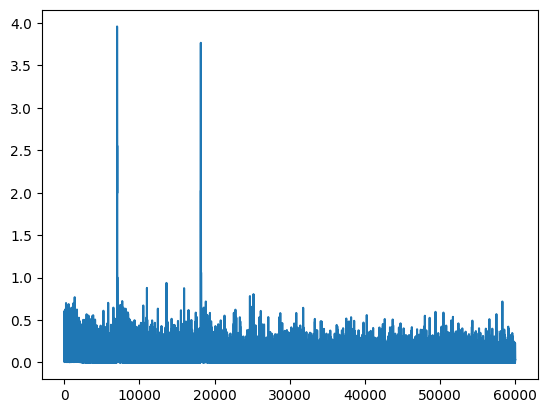

In [114]:
import torch 

# --------------------------------------------------------------- #
# Build the two-pose “dataset” using SciPy for rock-solid rotations
# --------------------------------------------------------------- #
def build_pose_dataset(device):
    """
    Returns a list [(R1,T1), (R2,T2)] where
      • Pose-1: 45° about +x,  translation (1, 0, 0)
      • Pose-2: 90° about +y,  translation (0, 0, −1)
    SciPy does the heavy lifting for rotation construction.
    """
    # Pose 1  (rotvec = axis * angle)
    rotvec1 = np.array([0.0, 0.0, 1.0]) * (np.pi / 4)          # 45° about x
    R1 = torch.tensor(Rot.from_rotvec(rotvec1).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R1)
    T1 = torch.tensor([1., 0., 0.], dtype=torch.float32, device=device)

    # Pose 2
    rotvec2 = np.array([0.0, 0.0, -1.0]) * (np.pi / 4)          # 90° about y
    R2 = torch.tensor(Rot.from_rotvec(rotvec2).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R2)
    T2 = torch.tensor([0., 0., -1.], dtype=torch.float32, device=device)

    return [(R1, T1), (R2, T2)]  # length-2 list of (R, T) tuples

def train_synthetic_pairs(diffuser, epochs=100, log_every=10000):
    B      = diffuser.batch_size
    device = diffuser.device
    dataset = build_pose_dataset(device)   # now SciPy-powered
    K = len(dataset)                       # =2

    losses = []
    for ep in range(1, epochs + 1):
        idx = torch.randint(high=K, size=(B,), device=device)   # (B,)
        Rs, Ts = zip(*[dataset[i] for i in idx.cpu().tolist()])
        Rs = torch.stack(Rs)    # (B,3,3)
        Ts = torch.stack(Ts)    # (B,3)

        loss = diffuser.train_step(Rs, Ts, ep)
        if(loss <= 10): 
            losses.append(loss)

        if ep % log_every == 0:
            print(f"[pair SE(3)] epoch {ep:4d} | loss {loss:.6f}")

    return losses

diffuser = se3_diffuser(T=100, batch_size=16, device="cpu")

# Step 2: Train on synthetic two-fixed-pose dataset
losses = train_synthetic_pairs(diffuser, epochs = 60000)

plt.plot(losses)

In [117]:
R, T = diffuser.sample()
R = R.squeeze(0)
print("R", R)
print("T", T)

print(R.T@R)


torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size

In [119]:
def plot_samples(num_samples=100, guidance=False, optim_steps=1, cost=None):
    rot_axes   = []
    trans_axes = []

    for _ in range(num_samples):
        R_sample, t_sample = diffuser.sample()      # R ∈ ℝ3×3 , t ∈ ℝ3
        R_sample = R_sample.squeeze(0)              # (3,3)
        t_sample = t_sample.squeeze(0)              # (3,)

        # ---- rotation axis ---------------------------------------------------
        omega  = Rot.from_matrix(R_sample).as_rotvec()
        theta  = np.linalg.norm(omega)
        if theta > 1e-5:
            axis = omega / theta
        else:                                       # identity – pick arbitrary axis
            axis = np.array([1.0, 0.0, 0.0])
        print(axis)
        rot_axes.append(axis)

        # ---- translation “axis” (unit-vector) --------------------------------
        trans_axis = t_sample / (np.linalg.norm(t_sample) + 1e-8)
        trans_axes.append(trans_axis)

    rot_axes   = np.stack(rot_axes)    # (N,3)
    trans_axes = np.stack(trans_axes)  # (N,3)

    # -------------------- plotting --------------------------------------------
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(111, projection='3d')

    ax.scatter(rot_axes[:,0],   rot_axes[:,1],   rot_axes[:,2], c='blue',  s=20, label='rotation axis')
    #ax.scatter(trans_axes[:,0], trans_axes[:,1], trans_axes[:,2], c='red',   s=20, label='translation axis')

    # unit-sphere wireframe for reference
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi,   100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc="upper right")
    plt.show()

    return theta, rot_axes

[-0.01543657 -0.00802349  0.99984866]
[0.3300085  0.94357077 0.02772339]
[-0.02263401  0.0055515  -0.9997284 ]
[-0.01603117 -0.00779122  0.99984114]
[-0.01631725 -0.00685939  0.99984334]
[-0.01675215 -0.0079486   0.99982808]
[-0.02288249  0.00673046 -0.99971551]
[-0.02313574  0.00530089 -0.99971828]
[ 0.99987467 -0.01574976  0.00161227]
[0.27879078 0.95994485 0.02795675]
[ 0.9771985  -0.21189077  0.01361574]
[-0.01665255 -0.00711951  0.99983599]
[-0.01621094 -0.00677343  0.99984565]
[-0.02254831  0.00490056 -0.99973374]
[-0.01603174 -0.0076328   0.99984235]
[-0.02296645  0.00557616 -0.99972069]
[-0.02321837  0.0054984  -0.9997153 ]
[-0.01655787 -0.00645868  0.99984205]
[-0.79237653  0.60983902 -0.01535581]
[-0.01573307 -0.00694886  0.99985208]
[-0.02328123  0.00596403 -0.99971117]
[-4.44857044e-01  8.95601357e-01 -6.48183278e-04]
[-0.01637654 -0.00649956  0.99984477]
[ 0.95965781  0.28095356 -0.01104451]
[ 9.99835479e-01  1.81363481e-02 -2.95844849e-04]
[-0.02315772  0.0068694  -0.9997

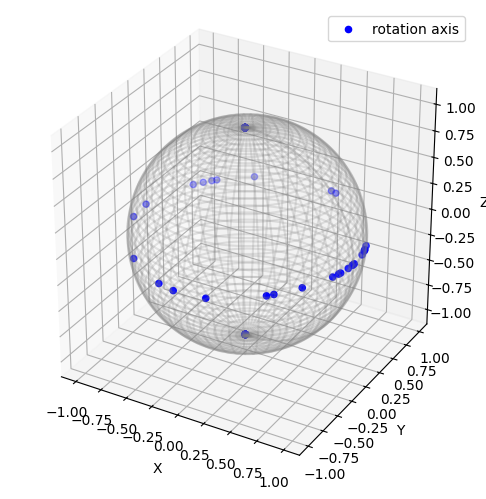

(0.8124655162405895,
 array([[-1.54365736e-02, -8.02348633e-03,  9.99848656e-01],
        [ 3.30008496e-01,  9.43570774e-01,  2.77233919e-02],
        [-2.26340125e-02,  5.55150394e-03, -9.99728404e-01],
        [-1.60311669e-02, -7.79121578e-03,  9.99841137e-01],
        [-1.63172536e-02, -6.85939271e-03,  9.99843336e-01],
        [-1.67521525e-02, -7.94859903e-03,  9.99828078e-01],
        [-2.28824918e-02,  6.73045581e-03, -9.99715506e-01],
        [-2.31357413e-02,  5.30088719e-03, -9.99718279e-01],
        [ 9.99874665e-01, -1.57497567e-02,  1.61226765e-03],
        [ 2.78790781e-01,  9.59944853e-01,  2.79567469e-02],
        [ 9.77198503e-01, -2.11890768e-01,  1.36157416e-02],
        [-1.66525484e-02, -7.11951445e-03,  9.99835989e-01],
        [-1.62109410e-02, -6.77343040e-03,  9.99845651e-01],
        [-2.25483090e-02,  4.90055668e-03, -9.99733744e-01],
        [-1.60317387e-02, -7.63279594e-03,  9.99842349e-01],
        [-2.29664492e-02,  5.57616308e-03, -9.99720685e-01],
   

In [126]:
""" GOAL DISTRIBUTION
    rotvec1 = np.array([0.0, 0.0, 1.0]) * (np.pi / 4)          # 45° about x
    R1 = torch.tensor(Rot.from_rotvec(rotvec1).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R1)
    T1 = torch.tensor([1., 0., 0.], dtype=torch.float32, device=device)

    # Pose 2
    rotvec2 = np.array([1.0, 0.0, 0.0]) * (np.pi / 2)          # 90° about y
    R2 = torch.tensor(Rot.from_rotvec(rotvec2).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R2)
    T2 = torch.tensor([0., 0., -1.], dtype=torch.float32, device=device)
"""
plot_samples(num_samples = 100)